In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/Birds'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 128

def load_images_from_folder(folder, limit=None):
    images_gray = []
    images_color = []
    count = 0
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, fname)
                img = cv2.imread(path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                color = img / 255.0
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                gray = np.expand_dims(gray, axis=-1) / 255.0

                images_gray.append(gray)
                images_color.append(color)

                count += 1
                if limit and count >= limit:
                    break

    images_gray = np.array(images_gray, dtype=np.float32)
    images_color = np.array(images_color, dtype=np.float32)
    return images_gray, images_color

X_train, Y_train = load_images_from_folder(train_dir)
X_test, Y_test = load_images_from_folder(test_dir)

In [ ]:
def build_colorization_model():
    inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    # Encoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)

    # Decoder
    x = UpSampling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    return Model(inp, out)

model = build_colorization_model()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 740,227 (2.82 MB)

 Trainable params: 740,227 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 0.0108 - val_loss: 0.0110


In [ ]:
preds = model.predict(X_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


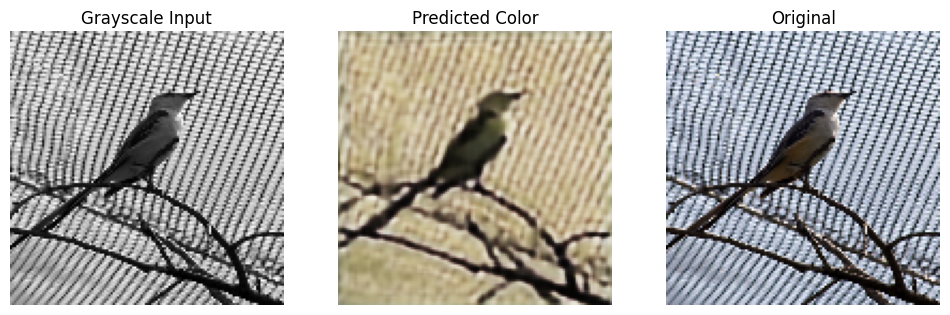

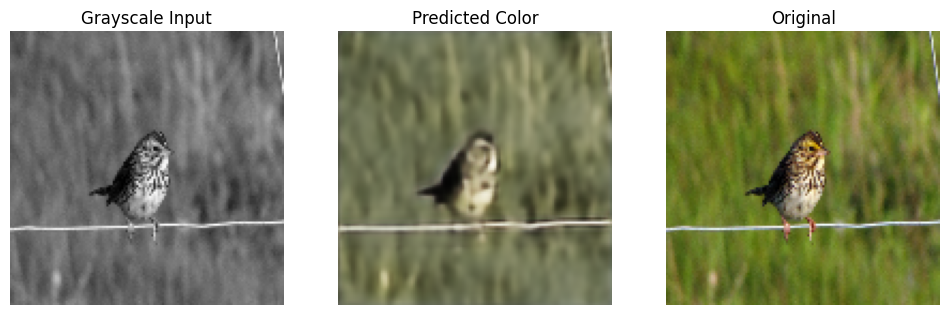

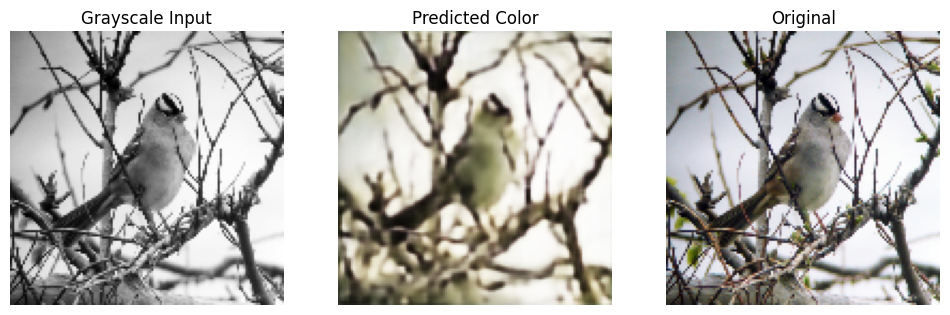

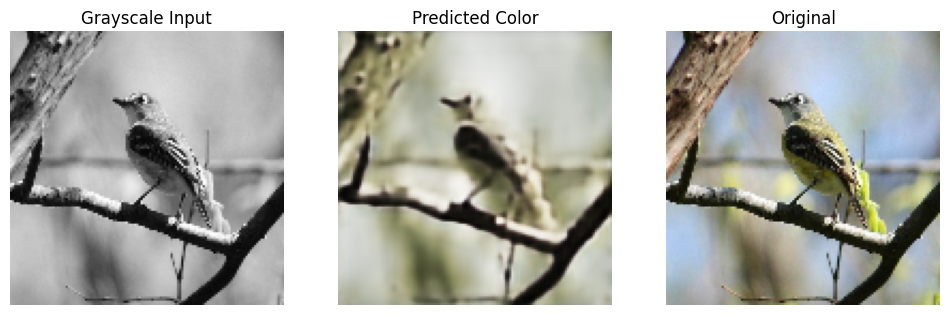

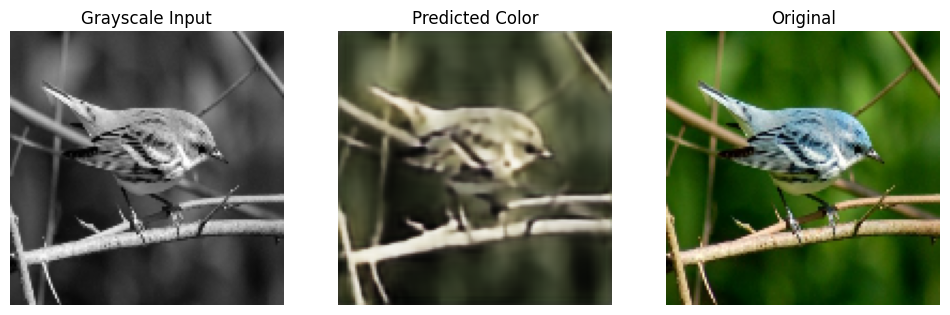

In [ ]:
for i in range(5):
    gray = X_test[i].reshape(IMG_SIZE, IMG_SIZE)
    pred = preds[i]
    orig = Y_test[i]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title('Grayscale Input')
    plt.imshow(gray, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title('Predicted Color')
    plt.imshow(pred)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title('Original')
    plt.imshow(orig)
    plt.axis('off')
    plt.show()